/opt/conda/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


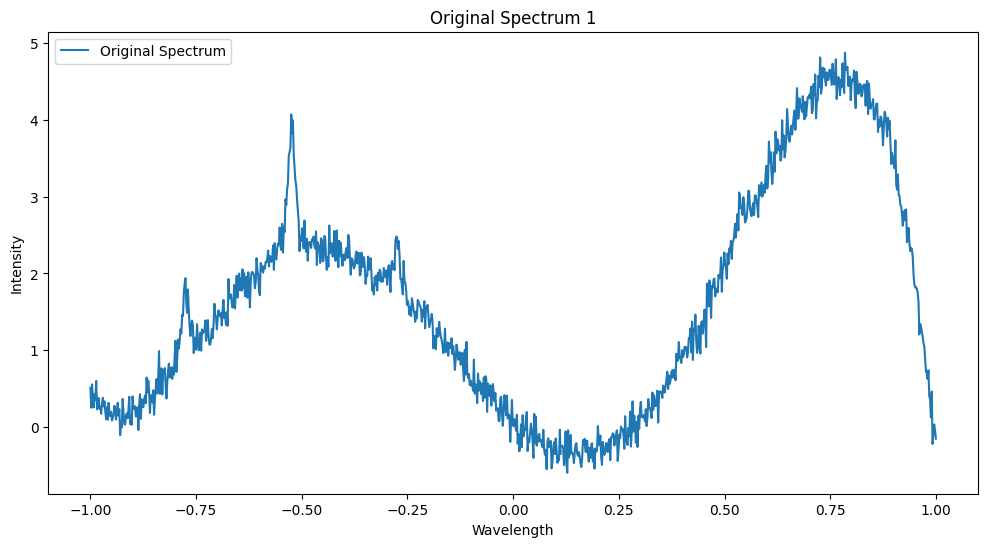

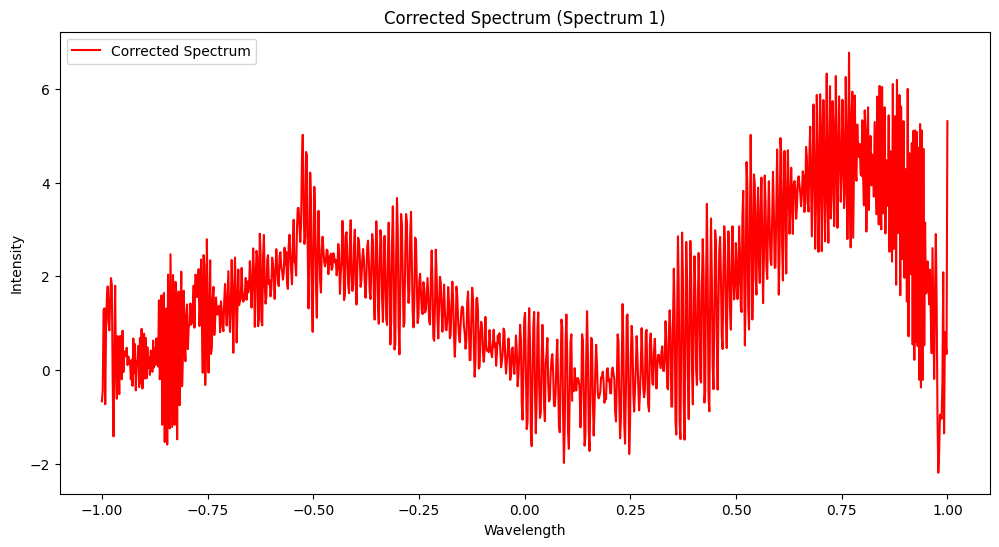

In [1]:
# 2) CORRECT BASELINE FITTING CHEBYSHEV POLYNOMIALS (ONE SPECTRUM)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define output directory
output_directory = '/kaggle/working/'

# Define file
combined_spectra_file = '/kaggle/input/synthdatas/synthetic_spectra_xy1.csv'

# Check if file exists
if os.path.isfile(combined_spectra_file):
    # Load data into a DataFrame
    combined_data = pd.read_csv(combined_spectra_file)

    # Number of spectra
    num_spectra = 1

    # List to store
    spectra = []
      
    # Split data into individual spectra
    spectrum_data_list = np.array_split(combined_data, num_spectra)

    # Define coeffs outside loop
    coeffs = []

    # 1. Identify Baseline Regions
    def identify_baseline_regions(intensities, min_peak_height=0.01):
        # Identify baseline regions in the spectrum
        # Parameters: intensities: Raman intensities as a numpy array & min_peak_height: Minimum peak height to consider a point as a peak
        # Returns: a list of tuples specifying start & end indices of baseline regions

        # Find local minima in spectrum
        is_peak = (intensities < np.roll(intensities, 1)) & (intensities < np.roll(intensities, -1))

        baseline_regions = []
        region_start = 0

        for i in range(1, len(intensities) - 1):
            if is_peak[i]:
                # If previous region is long enough, consider it a baseline region
                if i - region_start > 2:
                    baseline_regions.append((region_start, i))
                region_start = i + 1

        # Check if last region is a baseline region
        if region_start < len(intensities) - 1:
            baseline_regions.append((region_start, len(intensities) - 1))

        # Filter regions based on peak height
        baseline_regions = [region for region in baseline_regions if np.min(intensities[region[0]:region[1] + 1]) < min_peak_height]

        return baseline_regions

    # Iterate over each spectrum
    for spectrum_id in range(num_spectra):
        spectrum_data = spectrum_data_list[spectrum_id]

        # Extract relevant columns
        wavelengths = spectrum_data['Wavelength'].values
        intensities = spectrum_data['Intensity'].values

        # 2. Fit Chebyshev Polynomials to Baseline Regions
        baseline_regions = identify_baseline_regions(intensities)

        # Initialize coeffs_spectrum for current spectrum
        coeffs_spectrum = np.zeros(len(wavelengths))

        for start, end in baseline_regions:
            # Get wavelengths & intensities in baseline region
            baseline_wavelengths = wavelengths[start:end]
            baseline_intensities = intensities[start:end]

            # Fit Chebyshev polynomial to baseline region
            poly_order = 6
            coeffs_region = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)
            coeffs_spectrum[start:end] = np.polynomial.chebyshev.chebval(wavelengths[start:end], coeffs_region)

        # Append coeffs for current spectrum to coeffs list
        coeffs.append(coeffs_spectrum)

        # 3. Update Fitted Curve
        # Iterative loop to update fitted polynomial to ensure it remains beneath the spectrum
        # Set a maximum number of iterations to avoid infinite loops
        max_iterations = 10
        
        for iteration in range(max_iterations):
            # Evaluate fitted polynomial over entire spectrum range
            fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs_spectrum)

            # Check if any part of fitted curve is above the spectrum
            exceed_indices = np.where(fitted_baseline > intensities)[0]

            if len(exceed_indices) == 0:
                # If no part of fitted curve exceeds the spectrum, break loop
                break

            # Update coefficients where fitted curve exceeded the spectrum
            for index in exceed_indices:
                # Identify corresponding baseline region
                baseline_region = None
                for start, end in baseline_regions:
                    if start <= index <= end:
                        baseline_region = (start, end)
                        break

                if baseline_region is not None:
                    start, end = baseline_region
                    # Get wavelengths & intensities in baseline region
                    baseline_wavelengths = wavelengths[start:end]
                    baseline_intensities = intensities[start:end]

                    # Fit a new Chebyshev polynomial to baseline region
                    new_coeffs = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)

                    # Update coefficients where fitted curve exceeded the spectrum
                    coeffs_spectrum[start:end] = np.polynomial.chebyshev.chebval(wavelengths[start:end], new_coeffs)

        # 4. Subtract Fitted Polynomial
        # Evaluate fitted polynomial over entire spectrum range
        fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs_spectrum)

        # Subtract fitted baseline from original spectrum to correct baseline
        corrected_spectrum = intensities - fitted_baseline

        # Create a DataFrame for corrected spectrum
        corrected_df = pd.DataFrame({'Wavelength': wavelengths, 'Corrected_Intensity': corrected_spectrum})

        # Specify output file path for corrected spectrum
        corrected_file_path = os.path.join(output_directory, f'corrected_baseline_spectrum{spectrum_id}.csv')

        # Save DataFrame
        corrected_df.to_csv(corrected_file_path, index=False)

        # Plot original spectrum
        plt.figure(figsize=(12, 6))
        plt.plot(wavelengths, intensities, label="Original Spectrum")
        plt.title(f"Original Spectrum {spectrum_id + 1}")
        plt.xlabel("Wavelength")
        plt.ylabel("Intensity")
        plt.legend()

        # Plot corrected spectrum
        plt.figure(figsize=(12, 6))
        plt.plot(wavelengths, corrected_spectrum, label='Corrected Spectrum', color='red')
        plt.title(f'Corrected Spectrum (Spectrum {spectrum_id + 1})')
        plt.xlabel('Wavelength')
        plt.ylabel('Intensity')
        plt.legend()

        # Show plot
        plt.show()